# Parallel Processing
##### Sean Wade

In [17]:
import numpy as np
import itertools
from time import time
from ipyparallel import Client

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
client = Client()
dview = client[:]

In [16]:
%%time
def prob1():
    for i in range(10000000):
        np.random.random(10000000)

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 11 µs


In [18]:
%%time
def prob2():
    dview.execute("""
        import numpy as np
        for i in xrange(10000000):
        np.random.random(10000000)
        """)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


## Problem 3

In [41]:
def min_mean_max(n):
    """
    Write a function that returns the mean, max, and min for n draws
    from the standard normal distribution where n is default to 1,000,000.
    Use apply_sync() to execute this function across all available engines.
    Print the results as returned by each engine.
    """
    draws = np.random.random(n)
    return np.min(draws), np.mean(draws), np.max(draws)

def prob3(n=1000000):
    results = dview.apply_sync(min_mean_max, n)
    means_list, maxs_list, mins_list = [], [], []
    for group in results:
        mins_list.append(group[0])
        means_list.append(group[1])
        maxs_list.append(group[2])

    return means_list, mins_list, maxs_list

In [42]:
prob3()

([0.49955593888361821,
  0.50008541123031769,
  0.4999931576575653,
  0.49988056908650907],
 [2.6429445953990438e-07,
  3.4723737107889008e-07,
  1.0679749729014532e-07,
  3.7529388408064079e-07],
 [0.99999884721391163,
  0.99999963984177753,
  0.9999991439690693,
  0.99999843216998119])

## Problem 4

In [47]:
def min_mean_max_serial(n=1000000, num_cores=4):
    means_list, mins_list, maxs_list = [], [], []
    for _ in range(num_cores):
        mean, minimum, maximum = min_mean_max(n)
        means_list.append(mean)
        mins_list.append(minimum)
        maxs_list.append(maximum)
    return np.min(mins_list), np.mean(means_list), np.max(maxs_list)

In [57]:
def prob4():
    """
    Time the function from the previous problem in parallel and serially. Run
    apply_sync() on the function to time in parallel. To time the function
    serially, run the function in a for loop n times, where n is the number
    of engines on your machine. Print the results.
    """
    print "Parallel, Serial"
    serial_times = []
    parallel_times = []
    for n in [1e6, 5e6, 10e6, 15e6]: 
        n = int(n)
        # Serial
        start = time()
        min_mean_max_serial(n)
        end = time()
        serial = end - start
        
        # Parallel
        start = time()
        prob3(n)
        end = time()
        parallel = end - start
        
        print parallel, serial
            

In [58]:
prob4()

Parallel, Serial
0.0870640277863 0.146790981293
0.302826881409 0.363497972488
0.439807891846 0.690429925919
0.607664108276 1.08019900322


## Problem 5

In [69]:
def max_normal(N, num_draws):
    draws = []
    for _ in range(num_draws):
        draws.append(np.max(np.random.randn(N)))
    return draws

def prob5(N):
    """
    Accept an integer N that represents the number of draws to take from the
    normal distribution for the distribution X. Take 500,000 draws from this
    distribution and plot a histogram of the results. Split the load evenly
    among all available engines and make the function flexible to the number
    of engines running.
    """
    num_draws = 500000 / len(client.ids)
    results = dview.apply_sync(max_normal, N, int(num_draws))
    plt.hist(list(itertools.chain.from_iterable(results)))

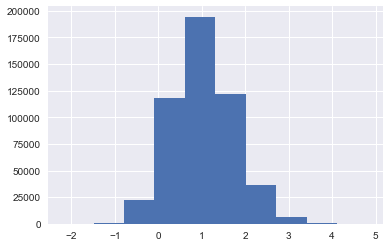

In [70]:
prob5(4)

## Problem 6

In [25]:
def parallel_trapezoidal_rule(f, a, b, n=200):
    """
    Write a function that accepts a function handle, f, bounds of integration,
    a and b, and a number of points to use, n. Split the interval of
    integration evenly among all available processors and use the trapezoidal
    rule to numerically evaluate the integral over the interval [a,b].

    Parameters:
        f (function handle): the function to evaluate
        a (float): the lower bound of integration
        b (float): the upper bound of integration
        n (int): the number of points to use, defaults to 200
    Returns:
        value (float): the approximate integral calculated by the
            trapezoidal rule
    """
    def parallel_area(f, x_lin):
        h = x_lin[1] - x_lin[0]
        area = 0
        for i in range(len(x_lin) - 1):
            a, b = f(x_lin[i]), f(x_lin[i+1])
            area += (a+b)*h/2
        return area
    dview['parallel_area'] = parallel_area

            
            
    x_lin = np.linspace(a, b, n)
    dview.scatter('x_lin_partition', x_lin)
    dview['f'] = f
    dview.execute("area_section = parallel_area(f, x_lin_partition)")
    results = dview.gather("area_section", block=True)
    return sum(results)

In [26]:
f = lambda x: x**2
a, b = 0, 2
parallel_trapezoidal_rule(f, a, b)

2.6314730644206219